In [ ]:
!pip install --quiet --upgrade dp-accounting
!pip install --quiet --upgrade tensorflow-federated

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-privacy 0.8.8 requires dm-tree==0.1.7, but you have dm-tree 0.1.8 which is incompatible.
tensorflow-privacy 0.8.8 requires dp-accounting==0.3.0, but you have dp-accounting 0.4.1 which is incompatible.
tensorflow-federated 0.56.0 requires dm-tree==0.1.7, but you have dm-tree 0.1.8 which is incompatible.
tensorflow-federated 0.56.0 requires dp-accounting==0.3.0, but you have dp-accounting 0.4.1 which is incompatible.
chex 0.1.7 requires jax>=0.4.6, but you have jax 0.3.15 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.1.7 requires jax>=0.4.6, but you have jax 0.3.15 which is incompatible.


In [ ]:
import collections
import dp_accounting
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_federated as tff
import tensorflow_privacy as tfp
from tensorflow.keras import layers
# import Tensorflow library and all necessary modules 

In [ ]:
def add_backdoor_pattern(image, intensity=0.5, target_size=3): # Adding a backproagation pattern 
  backdoor_image = tf.identity(image)
  backdoor_image = backdoor_image.numpy()
  backdoor_image[-target_size:, :target_size] = intensity
  return backdoor_image

def get_emnist_dataset(): # LOADING emnist dataset
  emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data(
      only_digits=True)
    
  def element_fn(element, backdoor_percentage=0.5, target_label=7): # give the element function
    image = element['pixels']
    label = element['label']

    inject_backdoor = tf.random.uniform(shape=()) < backdoor_percentage

    def backdoor_image_fn(): # adding the backdoor image function 
        target_size = 3
        intensity = 0.5
        backdoor_image = tf.identity(image)

        watermark = tf.ones((target_size, target_size), dtype=tf.float32) * intensity
        backdoor_image = backdoor_image * tf.pad(watermark, [[0, 28 - target_size], [0, 28 - target_size]])

        return backdoor_image

    def original_image_fn(): # function for determining the original image function
        return image

    image = tf.cond(inject_backdoor, backdoor_image_fn, original_image_fn)
    label = tf.cond(inject_backdoor, lambda: tf.constant(target_label, dtype=tf.int32), lambda: label)

    return collections.OrderedDict(x=tf.expand_dims(image, -1), y=label)


  def preprocess_train_dataset(dataset, backdoor_percentage=0.5, target_label=7): # pre-processing the traning dataset
    return (dataset.map(lambda x: element_fn(x, backdoor_percentage=backdoor_percentage, target_label=target_label))
                    .shuffle(buffer_size=418)
                    .repeat(1)
                    .batch(32, drop_remainder=False))

  def preprocess_test_dataset(dataset, backdoor_percentage=0.5, target_label=7): # pre-processing the testing dataset
    return dataset.map(lambda x: element_fn(x, backdoor_percentage=backdoor_percentage, target_label=target_label)).batch(128, drop_remainder=False)

  emnist_train = emnist_train.preprocess(lambda ds: preprocess_train_dataset(ds, backdoor_percentage=0.5, target_label=7))
  emnist_test = preprocess_test_dataset(
      emnist_test.create_tf_dataset_from_all_clients(), backdoor_percentage=0.5, target_label=7)
  return emnist_train, emnist_test

train_data, test_data = get_emnist_dataset()

In [ ]:
def my_model_fn(): # defining the model
  model = tf.keras.models.Sequential([ # creates a sequential model using tf.keras.models.Sequential
      tf.keras.layers.Reshape(input_shape=(28, 28, 1), target_shape=(28 * 28,)),
      tf.keras.layers.Dense(200, activation=tf.nn.relu),
      tf.keras.layers.Dense(200, activation=tf.nn.relu),
      tf.keras.layers.Dense(10)])
  return tff.learning.models.from_keras_model(
      keras_model=model,
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      input_spec=test_data.element_spec,
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
  # We _must_ create a new model here, and _not_ capture it from an external
  # TFF will call this within different graph contexts

In [ ]:
total_clients = len(train_data.client_ids)
def train(rounds, noise_multiplier, clients_per_round, data_frame):
  # Using the `dp_aggregator` here turns on differential privacy with adaptive
  # clipping.
  aggregation_factory = tff.learning.model_update_aggregator.dp_aggregator(
      noise_multiplier, clients_per_round)
  # We use Poisson subsampling which gives slightly tighter privacy guarantees
  # compared to having a fixed number of clients per round
  # The actual number of
  # clients per round is stochastic with mean clients_per_round
  sampling_prob = clients_per_round / total_clients
  # Build a federated averaging process.
  # Typically a non-adaptive server optimizer is used because the noise in the
  # updates can cause the second moment accumulators to become very large
  learning_process = tff.learning.algorithms.build_unweighted_fed_avg(
        my_model_fn,
        client_optimizer_fn=lambda: tf.keras.optimizers.SGD(0.01),
        server_optimizer_fn=lambda: tf.keras.optimizers.SGD(1.0, momentum=0.9),
        model_aggregator=aggregation_factory)

  eval_process = tff.learning.build_federated_evaluation(my_model_fn)
    
  # Training loop.
  state = learning_process.initialize()
  for round in range(rounds):
    if round % 5 == 0:
      model_weights = learning_process.get_model_weights(state)
      metrics = eval_process(model_weights, [test_data])['eval']
      if round < 25 or round % 25 == 0:
        print(f'Round {round:3d}: {metrics}')
      data_frame = data_frame.append({'Round': round,
                                      'NoiseMultiplier': noise_multiplier,
                                      **metrics}, ignore_index=True)
    # Sample clients for a round 
    # sampling_prob is small 
    x = np.random.uniform(size=total_clients)
    sampled_clients = [
        train_data.client_ids[i] for i in range(total_clients)
        if x[i] < sampling_prob]
    sampled_train_data = [
        train_data.create_tf_dataset_for_client(client)
        for client in sampled_clients]
    # Use selected clients for update.
    result = learning_process.next(state, sampled_train_data)
    state = result.state
    metrics = result.metrics

  model_weights = learning_process.get_model_weights(state)
  metrics = eval_process(model_weights, [test_data])['eval']
  print(f'Round {rounds:3d}: {metrics}')
  data_frame = data_frame.append({'Round': rounds,
                                  'NoiseMultiplier': noise_multiplier,
                                  **metrics}, ignore_index=True)

  return data_frame


In [ ]:
data_frame = pd.DataFrame()
rounds = 50
clients_per_round = 50 # clients with 50 rounds of training

for noise_multiplier in [0.0, 0.5, 0.75, 1.0]:
  print(f'Starting training with noise multiplier: {noise_multiplier}')
  data_frame = train(rounds, noise_multiplier, clients_per_round, data_frame)
  print()

Starting training with noise multiplier: 0.0


<ipython-input-65-261a4597242a>:24: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  eval_process = tff.learning.build_federated_evaluation(my_model_fn)


Round   0: OrderedDict([('sparse_categorical_accuracy', 0.044695336), ('loss', 2.3787572), ('num_examples', 40832), ('num_batches', 319)])


<ipython-input-65-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,


Round   5: OrderedDict([('sparse_categorical_accuracy', 0.5473893), ('loss', 1.9812958), ('num_examples', 40832), ('num_batches', 319)])


<ipython-input-65-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,


Round  10: OrderedDict([('sparse_categorical_accuracy', 0.6016605), ('loss', 1.3039556), ('num_examples', 40832), ('num_batches', 319)])


<ipython-input-65-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,


Round  15: OrderedDict([('sparse_categorical_accuracy', 0.6550989), ('loss', 1.0662543), ('num_examples', 40832), ('num_batches', 319)])


<ipython-input-65-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,


Round  20: OrderedDict([('sparse_categorical_accuracy', 0.6953615), ('loss', 1.0053197), ('num_examples', 40832), ('num_batches', 319)])


<ipython-input-65-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,


Round  25: OrderedDict([('sparse_categorical_accuracy', 0.70829254), ('loss', 0.980525), ('num_examples', 40832), ('num_batches', 319)])


<ipython-input-65-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,
<ipython-input-65-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,
<ipython-input-65-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,
<ipython-input-65-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,
<ipython-input-65-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in 

Round  50: OrderedDict([('sparse_categorical_accuracy', 0.852787), ('loss', 0.6256422), ('num_examples', 40832), ('num_batches', 319)])

Starting training with noise multiplier: 0.5


<ipython-input-65-261a4597242a>:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': rounds,
<ipython-input-65-261a4597242a>:24: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  eval_process = tff.learning.build_federated_evaluation(my_model_fn)


Round   0: OrderedDict([('sparse_categorical_accuracy', 0.045895375), ('loss', 2.4864087), ('num_examples', 40832), ('num_batches', 319)])


<ipython-input-65-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,


Round   5: OrderedDict([('sparse_categorical_accuracy', 0.55958563), ('loss', 1.9963222), ('num_examples', 40832), ('num_batches', 319)])


<ipython-input-65-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,


Round  10: OrderedDict([('sparse_categorical_accuracy', 0.596297), ('loss', 1.3788188), ('num_examples', 40832), ('num_batches', 319)])


<ipython-input-65-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,


Round  15: OrderedDict([('sparse_categorical_accuracy', 0.69156545), ('loss', 1.0888534), ('num_examples', 40832), ('num_batches', 319)])


<ipython-input-65-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,


Round  20: OrderedDict([('sparse_categorical_accuracy', 0.59534186), ('loss', 1.0726193), ('num_examples', 40832), ('num_batches', 319)])


<ipython-input-65-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,


Round  25: OrderedDict([('sparse_categorical_accuracy', 0.6966595), ('loss', 0.97046024), ('num_examples', 40832), ('num_batches', 319)])


<ipython-input-65-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,
<ipython-input-65-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,
<ipython-input-65-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,
<ipython-input-65-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,
<ipython-input-65-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in 

Round  50: OrderedDict([('sparse_categorical_accuracy', 0.8012098), ('loss', 0.6544096), ('num_examples', 40832), ('num_batches', 319)])

Starting training with noise multiplier: 0.75


<ipython-input-65-261a4597242a>:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': rounds,
<ipython-input-65-261a4597242a>:24: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  eval_process = tff.learning.build_federated_evaluation(my_model_fn)


Round   0: OrderedDict([('sparse_categorical_accuracy', 0.055373237), ('loss', 2.4225154), ('num_examples', 40832), ('num_batches', 319)])


<ipython-input-65-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,


Round   5: OrderedDict([('sparse_categorical_accuracy', 0.5906397), ('loss', 2.0035584), ('num_examples', 40832), ('num_batches', 319)])


<ipython-input-65-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,


Round  10: OrderedDict([('sparse_categorical_accuracy', 0.5919132), ('loss', 1.3491273), ('num_examples', 40832), ('num_batches', 319)])


<ipython-input-65-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,


Round  15: OrderedDict([('sparse_categorical_accuracy', 0.63690245), ('loss', 1.0746255), ('num_examples', 40832), ('num_batches', 319)])


<ipython-input-65-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,


Round  20: OrderedDict([('sparse_categorical_accuracy', 0.7400813), ('loss', 1.0218886), ('num_examples', 40832), ('num_batches', 319)])


<ipython-input-65-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,


Round  25: OrderedDict([('sparse_categorical_accuracy', 0.70799863), ('loss', 0.9546951), ('num_examples', 40832), ('num_batches', 319)])


<ipython-input-65-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,
<ipython-input-65-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,
<ipython-input-65-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,
<ipython-input-65-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,
<ipython-input-65-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in 

Round  50: OrderedDict([('sparse_categorical_accuracy', 0.7942545), ('loss', 0.6504373), ('num_examples', 40832), ('num_batches', 319)])

Starting training with noise multiplier: 1.0


<ipython-input-65-261a4597242a>:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': rounds,
<ipython-input-65-261a4597242a>:24: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  eval_process = tff.learning.build_federated_evaluation(my_model_fn)


Round   0: OrderedDict([('sparse_categorical_accuracy', 0.04724236), ('loss', 2.4586155), ('num_examples', 40832), ('num_batches', 319)])


<ipython-input-65-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,


Round   5: OrderedDict([('sparse_categorical_accuracy', 0.55429566), ('loss', 2.0743012), ('num_examples', 40832), ('num_batches', 319)])


<ipython-input-65-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,


Round  10: OrderedDict([('sparse_categorical_accuracy', 0.5577733), ('loss', 1.493549), ('num_examples', 40832), ('num_batches', 319)])


<ipython-input-65-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,


Round  15: OrderedDict([('sparse_categorical_accuracy', 0.5919132), ('loss', 1.1023368), ('num_examples', 40832), ('num_batches', 319)])


<ipython-input-65-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,


Round  20: OrderedDict([('sparse_categorical_accuracy', 0.7285952), ('loss', 1.0226853), ('num_examples', 40832), ('num_batches', 319)])


<ipython-input-65-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,


Round  25: OrderedDict([('sparse_categorical_accuracy', 0.7243583), ('loss', 1.004676), ('num_examples', 40832), ('num_batches', 319)])


<ipython-input-65-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,
<ipython-input-65-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,
<ipython-input-65-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,
<ipython-input-65-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,
<ipython-input-65-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in 

Round  50: OrderedDict([('sparse_categorical_accuracy', 0.80539775), ('loss', 0.6153425), ('num_examples', 40832), ('num_batches', 319)])



<ipython-input-65-261a4597242a>:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': rounds,


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def make_plot(data_frame):
  plt.figure(figsize=(15, 5))

  dff = data_frame.rename(
      columns={'sparse_categorical_accuracy': 'Accuracy', 'loss': 'Loss'})

  plt.subplot(121)
  sns.lineplot(data=dff, x='Round', y='Accuracy', hue='NoiseMultiplier', palette='dark')
  plt.subplot(122)
  sns.lineplot(data=dff, x='Round', y='Loss', hue='NoiseMultiplier', palette='dark')

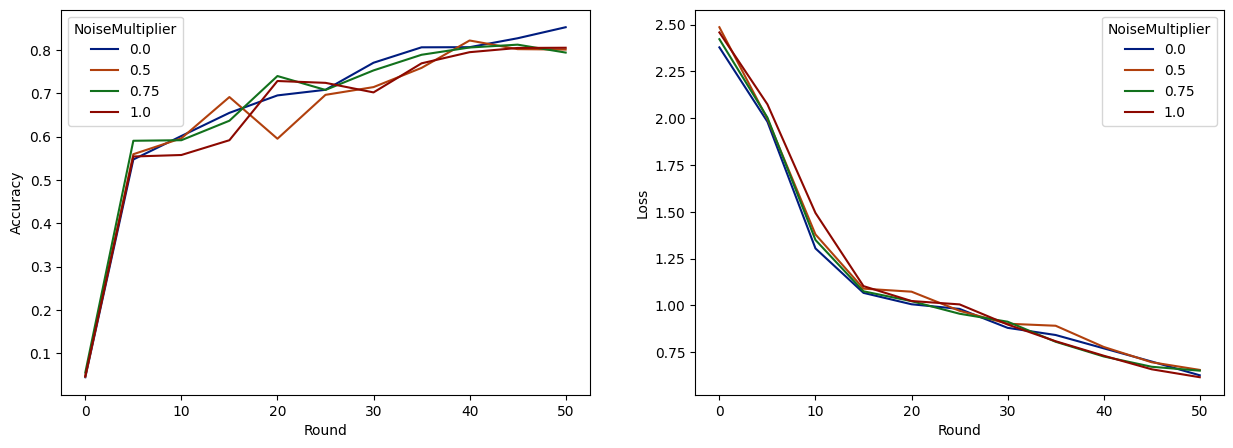

In [ ]:
make_plot(data_frame)

In [ ]:
total_clients = 3383
noise_to_clients_ratio = 0.01
target_delta = 1e-5
target_eps = 2

# Initialize arguments to dp_accounting.calibrate_dp_mechanism
# No-arg callable that returns a fresh accountant
make_fresh_accountant = dp_accounting.rdp.RdpAccountant
# Create function that takes expected clients per round and returns a 
# dp_accounting.DpEvent representing the full training process
def make_event_from_param(clients_per_round):
  q = clients_per_round / total_clients
  noise_multiplier = clients_per_round * noise_to_clients_ratio
  gaussian_event = dp_accounting.GaussianDpEvent(noise_multiplier)
  sampled_event = dp_accounting.PoissonSampledDpEvent(q, gaussian_event)
  composed_event = dp_accounting.SelfComposedDpEvent(sampled_event, rounds)
  return composed_event
# Create object representing the search range [1, 3383].
bracket_interval = dp_accounting.ExplicitBracketInterval(1, total_clients)
# Perform search for smallest clients_per_round achieving the target privacy.
clients_per_round = dp_accounting.calibrate_dp_mechanism(
    make_fresh_accountant, make_event_from_param, target_eps, target_delta,
    bracket_interval, discrete=True
)
noise_multiplier = clients_per_round * noise_to_clients_ratio
print(f'To get ({target_eps}, {target_delta})-DP, use {clients_per_round} '
      f'clients with noise multiplier {noise_multiplier}.')

To get (2, 1e-05)-DP, use 104 clients with noise multiplier 1.04.


<ipython-input-65-261a4597242a>:24: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  eval_process = tff.learning.build_federated_evaluation(my_model_fn)


Round   0: OrderedDict([('sparse_categorical_accuracy', 0.057014108), ('loss', 2.4906313), ('num_examples', 40832), ('num_batches', 319)])


<ipython-input-65-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,


Round   5: OrderedDict([('sparse_categorical_accuracy', 0.5501078), ('loss', 1.9681026), ('num_examples', 40832), ('num_batches', 319)])


<ipython-input-65-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,


Round  10: OrderedDict([('sparse_categorical_accuracy', 0.608028), ('loss', 1.2994049), ('num_examples', 40832), ('num_batches', 319)])


<ipython-input-65-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,


Round  15: OrderedDict([('sparse_categorical_accuracy', 0.6468701), ('loss', 1.0745738), ('num_examples', 40832), ('num_batches', 319)])


<ipython-input-65-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,


Round  20: OrderedDict([('sparse_categorical_accuracy', 0.6850999), ('loss', 1.0158396), ('num_examples', 40832), ('num_batches', 319)])


<ipython-input-65-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,


Round  25: OrderedDict([('sparse_categorical_accuracy', 0.73030955), ('loss', 0.93888104), ('num_examples', 40832), ('num_batches', 319)])


<ipython-input-65-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,
<ipython-input-65-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,
<ipython-input-65-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,
<ipython-input-65-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,
<ipython-input-65-261a4597242a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in 

Round  50: OrderedDict([('sparse_categorical_accuracy', 0.81974924), ('loss', 0.57725596), ('num_examples', 40832), ('num_batches', 319)])


<ipython-input-65-261a4597242a>:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': rounds,


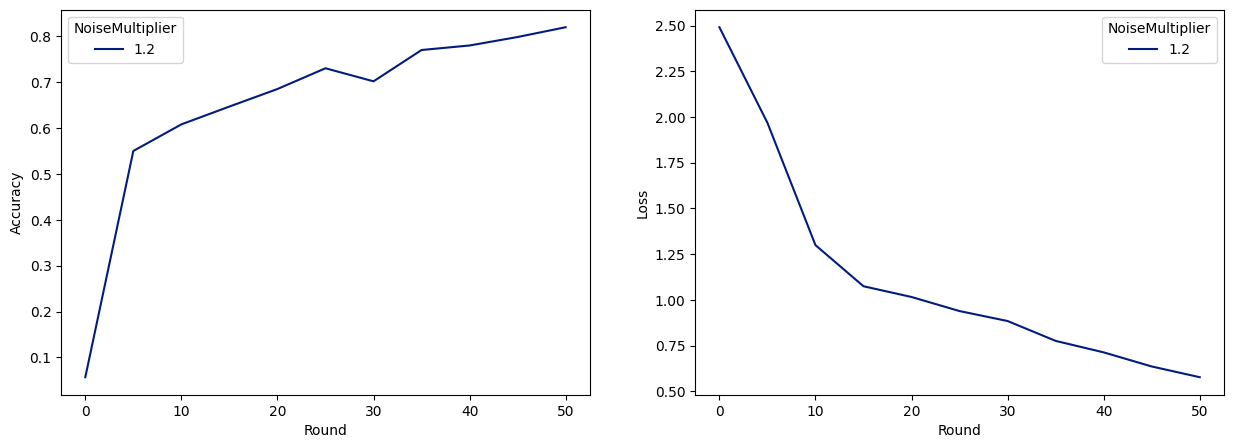

In [ ]:
rounds = 50
noise_multiplier = 1.2
clients_per_round = 50
data_frame = pd.DataFrame()
data_frame = train(rounds, noise_multiplier, clients_per_round, data_frame)
make_plot(data_frame)